## First try Final

1. collect data per month
2. create some kind of popularity score
3. separate in training and testing data
4. create GaussianMixture with training set
5. test the prediction with the test set



In [1]:
import sys
!{sys.executable} -m pip install pycoshark

  Using cached pycoSHARK-1.4.2-py3-none-any.whl
  Using cached pymongo-3.11.4-cp38-cp38-manylinux2014_x86_64.whl (531 kB)
  Using cached mongoengine-0.23.1-py3-none-any.whl (107 kB)


In [2]:
from mongoengine import connect, disconnect
from pycoshark.mongomodels import People, Commit, Project, VCSSystem, IssueSystem, Issue,PullRequestSystem, PullRequest, MailingList,Message
from pycoshark.utils import create_mongodb_uri_string
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None # FUCK OF PANDAS 

# Database credentials
user = 'datascience2021'
password = '43QAt5bd91'
host = '134.76.81.151'
port = '27017'
authentication_db = 'smartshark'
database = "smartshark"
ssl_enabled = None

# Establish connection
uri = create_mongodb_uri_string(user, password, host, port, authentication_db, ssl_enabled)
disconnect()
connect(database, host=uri)

MongoClient(host=['134.76.81.151:27017'], document_class=dict, tz_aware=False, connect=True, authsource='smartshark', read_preference=Primary())

### Project_handel
I Created a python class that gets initalized with the name of the porject and returns a dataset with pulls, commits, and issues, for each moth of each year


In [3]:
class Project_handel:
    def __init__(self, project_name):
        self.pName=project_name
        self.project = Project.objects(name=project_name).only('id').get()
    def get_commits(self):
        pipeline = [
            {
             "$group" : {
                   "_id": {
                    "year": { "$year" : "$committer_date" },        
                    "month": { "$month" : "$committer_date" },
                    #"day": { "$dayOfMonth" : "$committer_date" },
                },
                "commits": {"$sum": 1 }

             }}
            ]
        cur = list()
        for vcs_system in VCSSystem.objects(project_id=self.project.id).only('id','url'):
            cur+= list(Commit.objects.filter(vcs_system_id=vcs_system.id).aggregate(pipeline))
        return cur
    def get_issues(self):
        
        pipeline = [
            {
             "$group" : {
                   "_id": {
                    "year": { "$year" : "$created_at" },        
                    "month": { "$month" : "$created_at" },
                    #"day": { "$dayOfMonth" : "$committer_date" },
                },
                "issues": {"$sum": 1 }

             }}
            ]
        iss=list()
        for issue_system in IssueSystem.objects(project_id=self.project.id).only('id'):
            iss+= list(Issue.objects.filter(issue_system_id=issue_system.id).aggregate(pipeline))           
        
        return iss
    def get_pulls(self):
        pull = list()
        pipeline = [
            {
             "$group" : {
                   "_id": {
                    "year": { "$year" : "$merged_at" },        
                    "month": { "$month" : "$merged_at" },
                    #"day": { "$dayOfMonth" : "$committer_date" },
                },
                "pulls": {"$sum": 1 }

             }}
            ]

        for pull_system in PullRequestSystem.objects(project_id=self.project.id).only('id'):
            pull+=list(PullRequest.objects.filter(pull_request_system_id=pull_system.id).aggregate(pipeline))
        return pull

    def getDf(self): 
        cur_co=self.get_commits()
        data_co = list(cur_co)
        df_co = pd.json_normalize(data_co)
        df_co = df_co.dropna()
        
        data_is=self.get_issues()
        df_is = pd.json_normalize(data_is)
        df_is = df_is.dropna()
        
        data_pu = self.get_pulls()
        df_pu = pd.json_normalize(data_pu)
        df_pu =df_pu.dropna()
     
        df = pd.merge(df_co,df_is, on=["_id.year","_id.month"],how='outer')
        if(not(df_pu.empty)):
            df = pd.merge(df,df_pu, on=["_id.year","_id.month"],how='outer')
        else:
            df['pulls']=[0]*len(df['_id.year'])
        df.fillna(0, inplace=True)
        cols=["_id.year","_id.month"]
        df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
        return df



Since the populariy score is based on the avarage pulls, issus and commits I first created an dataset with all projects

In [4]:
project_names=["ant-ivy", "archiva", "calcite", "cayenne", "commons-bcel", "commons-beanutils", "commons-codec", "commons-collections", "commons-compress", "commons-configuration", "commons-dbcp", "commons-digester", "commons-io", "commons-jcs", "commons-jexl", "commons-lang", "commons-math", "commons-net", "commons-rdf", "commons-scxml", "commons-validator", "commons-vfs", "deltaspike", "eagle", "giraph", "gora", "jspwiki", "kylin", "lens", "mahout", "manifoldcf", "nutch", "opennlp", "parquet-mr", "santuario-java", 
               "systemml", 
               "tika", "wss4j"]

In [5]:
dfs=[]
for n in project_names:
    df= Project_handel(n).getDf()
    df['_id.project']=n
    dfs.append(df)
all_df=pd.concat(dfs)


the popularity score:
$$ popularity_i = \frac{\frac{pulls_i}{pulls_Ø}+\frac{issues_i}{issues_Ø}\frac{commits_i}{commits_Ø}}{3}$$

is added to the dataframe all_df using the apply function

In [6]:
pull_mean=np.mean(all_df['pulls'])
commit_mean=np.mean(all_df['commits'])
issue_mean=np.mean(all_df['issues'])
cols=["pulls","commits","issues"]
all_df['popo'] = all_df[cols].apply(lambda x: ((x[0]/pull_mean)+(x[1]/commit_mean)+(x[2]/issue_mean))/3, axis="columns")
cols=["_id.project","date"]
all_df['id'] = all_df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

Next I devied the projects in to a train set and a test set

In [7]:
train_name=["ant-ivy", "archiva", "calcite", "cayenne", "commons-bcel", "commons-beanutils", "commons-codec", "commons-collections", "commons-compress", "commons-configuration", "commons-dbcp", "commons-digester", "commons-io"]
test_name=["commons-jcs", "commons-jexl", "commons-lang", "commons-math", "commons-net", "commons-rdf", "commons-scxml", "commons-validator", "commons-vfs", "deltaspike", "eagle", "giraph", "gora", "jspwiki", "kylin", "lens", "mahout", "manifoldcf", "nutch", "opennlp", "parquet-mr", "santuario-java", "systemml", "tika", "wss4j"]
#train_df=all_df.where(all_df['_id.project'].item(train_name))
train_df=all_df[all_df['_id.project'].isin(train_name)]
test_df=all_df[all_df['_id.project'].isin(test_name)]

test_df

commits  _id.year  _id.month  issues  pulls         date  _id.project  \
0        2.0    2014.0        9.0     3.0    0.0   2014.0-9.0  commons-jcs   
1       22.0    2008.0       12.0     0.0    0.0  2008.0-12.0  commons-jcs   
2        6.0    2016.0        1.0     3.0    0.0   2016.0-1.0  commons-jcs   
3       13.0    2003.0        2.0     0.0    0.0   2003.0-2.0  commons-jcs   
4       11.0    2002.0        8.0     0.0    0.0   2002.0-8.0  commons-jcs   
..       ...       ...        ...     ...    ...          ...          ...   
174      0.0    2020.0        6.0     0.0    1.0   2020.0-6.0        wss4j   
175      0.0    2020.0        2.0     0.0    2.0   2020.0-2.0        wss4j   
176      0.0    2019.0       11.0     0.0    1.0  2019.0-11.0        wss4j   
177      0.0    2020.0       12.0     0.0    1.0  2020.0-12.0        wss4j   
178      0.0    2020.0        4.0     0.0    3.0   2020.0-4.0        wss4j   

         popo                       id  
0    0.162341   commons-jcs-2014.0-9.0  
1    0.303184  commons-jcs-2008.0-12.0  
2    0.217465   commons-jcs-2016.0-1.0  
3    0.179154   commons-jcs-2003.0-2.0  
4    0.151592   commons-jcs-2002.0-8.0  
..        ...                      ...  
174  0.450082         wss4j-2020.0-6.0  
175  0.900164         wss4j-2020.0-2.0  
176  0.450082        wss4j-2019.0-11.0  
177  0.450082        wss4j-2020.0-12.0  
178  1.350245         wss4j-2020.0-4.0  

[3460 rows x 9 columns]

### create Model
using commits, issues and pulls of the trian_df
It can be change between gaussianMixture and Kmeans in the code

In [8]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
train_np = train_df[['commits', 'issues','pulls']].to_numpy()
model_gm = GaussianMixture(n_components=5,random_state=0).fit(train_np)
#model_gm =KMeans(n_clusters=5).fit(train_np)
pred_gm=model_gm.predict(train_np)
train_df['gm']=pred_gm




### Identify the labels
by using the  groupby function and mean()
and creating labels for the gm based on the highest mean(popo)

In [9]:
label_train=train_df.groupby('gm').mean()
type(label_train)
label_train=label_train.sort_values(by=['popo'])
label_train['label']=["--","-","o","+","++"]
label_train=label_train.sort_values(by=['gm'])
label_train['label']

gm
0     +
1     o
2    ++
3    --
4     -
Name: label, dtype: object

creating an array of labels for the plot

In [10]:
labels=list(label_train['label'])

Using the model on the test_df

In [11]:
test_np = test_df[['commits', 'issues','pulls']].to_numpy()
test_df['gm']=model_gm.predict(test_np)

add labels based on the train set to the test set 

In [12]:
test_df['label']=test_df['gm'].apply(lambda x: labels[x])

createing the mean of the popularity for the test_df and adding the gm row to both result dataframes since pandas is mean to me

In [13]:
label_test=test_df.groupby('gm').mean()
if(len(label_test)==4):
    label_test['gm']=[0,1,2,3]
else:
    label_test['gm']=[0,1,2,3,4]    
label_train['gm']=[0,1,2,3,4]

Creating a barplot 

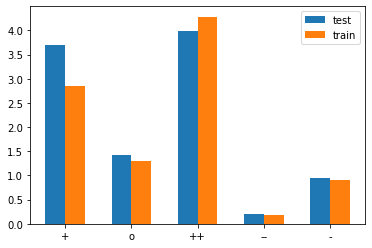

In [14]:
import matplotlib.pyplot as plt
plt.bar(label_test['gm']-0.15,label_test['popo'],width=0.3)
plt.bar(label_train['gm']+0.15,label_train['popo'],width=0.3)
plt.legend(['test','train'])
plt.xticks([0, 1, 2,3,4], labels)
plt.show()


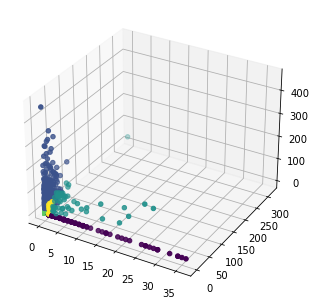

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
#km_test_3d = df_all[['pulls', 'commits', 'submits']].to_numpy()

ax.scatter(train_np[:,2], train_np[:,1], train_np[:,0], c=train_df['gm'])

In [29]:
import requests
import datetime

In [30]:
class ApiHandel:
    def __init__(self,user,name):
        self.headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.35'}
        self.pullURL="https://api.github.com/repos/"+user+"/"+name+"/pulls"
        self.commitURL="https://api.github.com/repos/"+user+"/"+name+"/commits"
        self.issueURL="https://api.github.com/repos/"+user+"/"+name+"/issues"
        self.StartDate=datetime.datetime.today().replace(month=datetime.datetime.today().month-1)
    def getPulls(self,page=0):
        r = requests.get(self.pullURL+"?page="+str(page)+"&per_page=100",self.headers)
        print(r)
        return r.json()
    def getCommits(self,page=0):
        print(self.commitURL+"?page="+str(page)+"&per_page=100")
        r= requests.get(self.commitURL+"?page="+str(page)+"&per_page=100",self.headers)
        print(r)
        return r.json()
    def getIssues(self,page=0):
        r= requests.get(self.issueURL+"?page="+str(page)+"&per_page=100",self.headers)
        print(r)
        return r.json()
    def countCommits(self):
        i =1
        count=0
        running = True
        while(running):
            for p in self.getCommits(i):
                dateStr=p['commit']['committer']['date'].split("T")[0]
                format="%Y-%m-%d"
                dt_object = datetime.datetime.strptime(dateStr, format)
                if(dt_object>self.StartDate):
                    count+=1
                else:
                    running=False
            i+=1
        return count
    def countPulls(self):
        i =1
        count=0
        running = True
       # while(running):
        for p in self.getPulls(i):
            dateStr=p['created_at'].split("T")[0]
            format="%Y-%m-%d"
            dt_object = datetime.datetime.strptime(dateStr, format)
            if(dt_object>self.StartDate):
                count+=1
            else:
                running=False
        i+=1
        return count
    
    def countIssues(self):
        i =1
        count=0
        running = True
       # while(running):
        for p in self.getIssues(i):
            dateStr=p['created_at'].split("T")[0]
            format="%Y-%m-%d"
            dt_object = datetime.datetime.strptime(dateStr, format)
            if(dt_object>self.StartDate):
                count+=1
            else:
                running=False
        i+=1
        return count
    def createSetting(self):
        return [self.countCommits(),self.countIssues(),self.countPulls()]

In [44]:
erg=ApiHandel("rcmaehl","WhyNotWin11").createSetting()

https://api.github.com/repos/rcmaehl/WhyNotWin11/commits?page=1&per_page=100
<Response [200]>
https://api.github.com/repos/rcmaehl/WhyNotWin11/commits?page=2&per_page=100
<Response [200]>
https://api.github.com/repos/rcmaehl/WhyNotWin11/commits?page=3&per_page=100
<Response [200]>
https://api.github.com/repos/rcmaehl/WhyNotWin11/commits?page=4&per_page=100
<Response [200]>
https://api.github.com/repos/rcmaehl/WhyNotWin11/commits?page=5&per_page=100
<Response [200]>
https://api.github.com/repos/rcmaehl/WhyNotWin11/commits?page=6&per_page=100
<Response [200]>
https://api.github.com/repos/rcmaehl/WhyNotWin11/commits?page=7&per_page=100
<Response [200]>
https://api.github.com/repos/rcmaehl/WhyNotWin11/commits?page=8&per_page=100
<Response [200]>
https://api.github.com/repos/rcmaehl/WhyNotWin11/commits?page=9&per_page=100
<Response [200]>
https://api.github.com/repos/rcmaehl/WhyNotWin11/commits?page=10&per_page=100
<Response [200]>
https://api.github.com/repos/rcmaehl/WhyNotWin11/commits?pa

TypeError: string indices must be integers

In [43]:
labels[model_gm.predict([erg])[0]]

'++'

In [42]:
erg

[0, 10, 6]